# Data Challenge 2 - Reorder Sentences

Submitted by: Siqi Liu

Student ID: 20428295

WatIAm: sq2liu

* [Introduction](#intro)
* [Scripts](#scr)
    - [Config](#scr-config)
    - [Utilities](#scr-utils)
    - [Data](#scr-data)
    - [Model](#scr-model)
    - [Graph](#scr-graph)
* [Set-Up](#setup)
* [Data](#data)
* [First Sentence Classifier](#fsent)
    - [Create Datasets, Samplers and DataLoders](#fsent-data)
    - [Load Pre-Trained Model](#fsent-load-model)
    - [Initialize Optimizer and Scheduler](#fsent-opt-sch)
    - [Train Model](#fsent-train-model)
    - [Plot Statistics](#fsent-plots)
* [Sentence Pair Classifier](#pair)
    - [Create Training Dataset, Sampler and DataLoder](#pair-data)
    - [Load Pre-Trained Model](#pair-load-model)
    - [Initialize Optimizer and Scheduler](#pair-opt-sch)
    - [Train Model](#pair-train-model)
    - [Plot Statistics](#pair-plots)
* [Submission](#submission)

<a id="intro"></a>
## Introduction

For this data challenge, we create models to reorder a given set of sentences from Wikipedia.

We take a two-step approach:

1. We use a BERT sequence classifier to predict the first sentence in the given set of sentences. We recognize that the first sentence usually has distinct characteristics and patterns (e.g., Person-Date-Date)
2. We use another BERT sequence classifier to predict pairwise orders between two sentences - if sentence A appears before sentence B, then the label is 0, otherwise 1. The order does NOT have to be consecutive

Using the results from the two classifers, we can construct a directed graph - each sentence forms a node and the logits from the pairwise classifer become the edge weights. To form a prediction, we simply search for the path (starting from the predicted first sentence/node) that maximizes the total pairwise edge weights.

We randomly select 10,000/500 documents from the labeled dataset as our training/validation set respectively.

We use WeightedRandomSampler with a target ratio of 0.5 for the first sentence classifier to accommodate the class imbalance, and simple RandomSampler for the pairwise classifier since the class ratio is already balanced.

For model selection, we use validation accuracy for the first sentence classifier and validation mean column-wise Spearman correlation for the pairwise classifier.

<a id="scr"></a>
## Scripts

<a id="scr-config"></a>
### Config

In [1]:
args = {
    'dir': '/kaggle/input/stat946winter2021dc2/',
    'labeled_filename': 'train.pkl',
    'pred_filename': 'test.pkl',
    'seed': 647,
    'num_train_docs': int(1e5),
    'num_val_docs': int(5e2),
    'model_type': 'bert-base-uncased',
    'do_lower_case': True,
    'graph_method': 'max_flow',
    'model_fsent': {
        'max_length': 64,
        'num_train_samples': int(1e4),
        'target_ratio': 0.5,
        'num_epochs': 10,
        'batch_size': 32,
        'lr': 5e-5,
        'adam_eps': 1e-8,
        'warmup_steps': 0
    },
    'model_pair': {
        'max_length': 128,
        'num_train_samples': int(3e4),
        'num_epochs': 30,
        'batch_size': 32,
        'lr': 5e-5,
        'adam_eps': 1e-8,
        'warmup_steps': 0
    }
}

<a id="scr-utils"></a>
### Utilities

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt


def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Current device: {:s}".format(device.type))
    return device


def set_seed():
    seed = args['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def plot_statistics(measure, values):
    fig = plt.figure(figsize=(10, 5))
    plt.title("Measure: {}".format(measure))
    for label, value in values.items():
        plt.plot(value, label=label)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(measure)
    plt.legend(loc='best')


<a id="scr-data"></a>
### Data

In [3]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from itertools import combinations
from collections import namedtuple, Counter
from math import floor
import torch
import pickle

def load_dataset(file):
    dataset = pickle.load(open(file, 'rb'))
    print("{:s} loaded. Size: {:d}".format(file, len(dataset)))
    return dataset


def get_train_val_set(dataset, num_val, num_train=None):
    set_seed()
    if num_train:
        retain_set = random.sample(dataset, num_train + num_val)
    else:
        retain_set = dataset
    train_set, val_set = train_test_split(retain_set, test_size=num_val)
    print("train_set size: {:d}\nval_set size: {:d}".format(
        len(train_set), len(val_set)
    ))
    return train_set, val_set


def get_fsents(dataset):
    fsents = []
    for i, doc in enumerate(dataset):
        for j, text in enumerate(doc['sentences']):
            if doc['indexes'][j] == 0:
                fsents.append(text)
    return fsents


Sentence = namedtuple('Sentence', ('guid', 'text', 'index', 'label'))


def clean_text(text):
    return text


class FirstSentenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.sentences, self.labels = self._get_sentences(data)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _get_sentences(self, data):
        sentences = []
        labels = []
        for i, doc in enumerate(data):
            for j, text in enumerate(doc['sentences']):
                guid = '{:d}-{:d}'.format(i, j)
                index = doc['indexes'][j]
                label = 1 if index == 0 else 0
                labels.append(label)
                sentences.append(Sentence(guid, text, index, label))
        print("Dataset loaded. Size: {:d}".format(len(sentences)))
        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        cleaned_text = clean_text(sentence.text)

        encoding = self.tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,  # single sentence, do not need
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'guid': sentence.guid,
            'text': sentence.text,
            'cleaned_text': cleaned_text,
            'index': sentence.index,
            'label': torch.LongTensor([sentence.label]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


SentencePair = namedtuple('SentencePair',
                          ('guid', 'text_a', 'text_b',
                           'index_a', 'index_b', 'label')
                          )


class SentencePairDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.sentence_pairs, self.labels = self._get_sentence_pairs(data)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _get_sentence_pairs(self, data):
        set_seed()
        sentence_pairs = []
        labels = []
        for i, doc in enumerate(data):
            # all pairwise combinations of the sentences
            perms = list(combinations(enumerate(doc['sentences']), 2))
            for (a, text_a), (b, text_b) in perms:
                guid = "{:d}-{:d}-{:d}".format(i, a, b)
                # gold indexes
                index_a = doc['indexes'][a]
                index_b = doc['indexes'][b]
                # assign predecessor and successor
                if index_a < index_b:
                    index_pred, index_succ = index_a, index_b
                    text_pred, text_succ = text_a, text_b
                else:
                    index_pred, index_succ = index_b, index_a
                    text_pred, text_succ = text_b, text_a
                # randomly decide what to predict
                r = random.random()
                if r >= 0.5:
                    # true sample
                    labels.append(1)
                    sentence_pairs.append(SentencePair(
                        guid, text_pred, text_succ, index_pred, index_succ, 1
                    ))
                else:
                    # false sample
                    labels.append(0)
                    sentence_pairs.append(SentencePair(
                        guid, text_succ, text_pred, index_succ, index_pred, 0
                    ))
        print("Dataset loaded. Size: {:d}".format(len(sentence_pairs)))
        return sentence_pairs, labels

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, index):
        sentence_pair = self.sentence_pairs[index]
        cleaned_text_a = clean_text(sentence_pair.text_a)
        cleaned_text_b = clean_text(sentence_pair.text_b)

        encoding = self.tokenizer.encode_plus(
            cleaned_text_a,
            cleaned_text_b,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if len(encoding['input_ids']) > self.max_length:
            cleaned_text_a, cleaned_text_b = truncate_texts(
                cleaned_text_a,
                cleaned_text_b,
                self.tokenizer,
                self.max_length
            )
            encoding = self.tokenizer.encode_plus(
                cleaned_text_a,
                cleaned_text_b,
                add_special_tokens=True,
                max_length=self.max_length,
                return_token_type_ids=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            assert len(encoding['input_ids']) <= self.max_length

        return {
            'guid': sentence_pair.guid,
            'text_a': sentence_pair.text_a,
            'text_b': sentence_pair.text_b,
            'cleaned_text_a': cleaned_text_a,
            'cleaned_text_b': cleaned_text_b,
            'index_a': sentence_pair.index_a,
            'index_b': sentence_pair.index_b,
            'label': torch.LongTensor([sentence_pair.label]),
            'input_ids': encoding['input_ids'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


def truncate_texts(text_a, text_b, tokenizer, max_length):
    # exclude [CLS] and [SEP]
    encoding_a = tokenizer.encode(text_a)
    length_a = len(encoding_a) - 2
    encoding_b = tokenizer.encode(text_b)
    length_b = len(encoding_b) - 2
    # exclude [CLS] and [SEP] x 2
    max_length_each = floor((max_length - 3) / 2)
    if length_a < max_length_each:
        # a is okay, truncate b
        text_b = tokenizer.decode(
            encoding_b[1:max_length - 3 - length_a + 1]
        )
    elif length_b < max_length_each:
        # b is okay, truncate a
        text_a = tokenizer.decode(
            encoding_a[1:max_length - 3 - length_b + 1]
        )
    else:
        # truncate both
        text_a = tokenizer.decode(
            encoding_a[1:max_length_each + 1]
        )
        text_b = tokenizer.decode(
            encoding_b[1:max_length_each + 1]
        )
    return text_a, text_b


def get_weights_for_balanced_classes(dataset, target_ratio=0.5):
    labels = dataset.labels
    label_counts = Counter(labels)
    num_ones = label_counts[1]
    num_zeros = label_counts[0]
    weight_one = target_ratio / (1 - target_ratio) * (num_zeros / num_ones)
    print("Weight for Ones: {:.4f}".format(weight_one))
    return [weight_one if label == 1 else 1 for label in labels], weight_one


<a id="scr-model"></a>
### Model

In [4]:
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
import torch
import time
import copy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import spearmanr


def load_model():
    return BertForSequenceClassification.from_pretrained(
        args['model_type'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )


def load_tokenizer():
    return BertTokenizer.from_pretrained(
        args['model_type'],
        do_lower_case=args['do_lower_case']
    )


def get_optimizer(model, lr, eps):
    return AdamW(
        model.parameters(),
        lr=lr,
        eps=eps
    )


def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    return get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )


def train_fsent(model, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs):
    # set seed
    set_seed()

    # starting time
    since = time.time()

    # store model that yields the highest accuracy in the validation set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    # keep track of the statistics
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # loss and number of correct predictions
            running_loss = 0.0
            running_corrects = 0
            running_data = 0

            # iterate over each batch
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for batch in tepoch:
                    # Unravel inputs
                    input_ids = batch['input_ids'].to(device)
                    token_type_ids = None
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    # reset the parameter gradients
                    optimizer.zero_grad()
                    model.zero_grad()

                    # forward
                    # track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(
                            input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels
                        )
                        loss = outputs.loss
                        logits = outputs.logits
                        preds = torch.argmax(logits, axis=1)

                        # backward only if in training
                        if phase == 'train':
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(),
                                1.0
                            )
                            optimizer.step()
                            scheduler.step()

                    # add to statistics
                    running_loss += loss.item() * len(labels)
                    running_corrects += torch.sum(
                        preds == labels.data.flatten()
                    )
                    running_data += len(labels)

                    # update progress bar
                    tepoch.set_postfix(
                        loss=(running_loss / running_data),
                        accuracy=(running_corrects.item() / running_data)
                    )
                    time.sleep(0.1)

            # compute loss and accuracy at epoch level
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            # deep copy the model when epoch accuracy (on validation set) is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                torch.save(model, 'fsent_model_checkpoint.pt')
                print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Val Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies


def train_pair(model, model_fsent, tokenizer, device, val_set, train_dataloader, optimizer, scheduler, num_epochs):
    # set seed
    set_seed()

    # starting time
    since = time.time()

    # store model that yields the highest Spearman correlation in the validation set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_spearman = float('-inf')
    best_epoch = 0

    # keep track of the statistics
    losses = {'train': []}
    accuracies = {'train': []}
    spearmans = {'val': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()  # set model to training mode

                # loss and number of correct predictions
                running_loss = 0.0
                running_corrects = 0
                running_data = 0

                # iterate over each batch
                with tqdm(train_dataloader, unit="batch") as tepoch:
                    for batch in tepoch:
                        # Unravel inputs
                        input_ids = batch['input_ids'].to(device)
                        token_type_ids = batch['token_type_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['label'].to(device)

                        # number of data points
                        n_data = len(labels)

                        # reset the parameter gradients
                        optimizer.zero_grad()
                        model.zero_grad()

                        # forward
                        # track history only in train
                        with torch.set_grad_enabled(True):
                            outputs = model(
                                input_ids=input_ids,
                                token_type_ids=token_type_ids,
                                attention_mask=attention_mask,
                                labels=labels
                            )
                            loss = outputs.loss
                            logits = outputs.logits
                            preds = torch.argmax(logits, axis=1)

                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(),
                                1.0
                            )
                            optimizer.step()
                            scheduler.step()

                        # add to statistics
                        running_loss += loss.item() * n_data
                        running_corrects += torch.sum(
                            preds == labels.data.flatten()
                        )
                        running_data += n_data

                        # update progress bar
                        tepoch.set_postfix(
                            loss=(running_loss / running_data),
                            accuracy=(running_corrects.item() / running_data)
                        )
                        time.sleep(0.1)

                # compute loss and accuracy at epoch level
                epoch_loss = running_loss / running_data
                epoch_acc = running_corrects.double() / running_data
                losses['train'].append(epoch_loss)
                accuracies['train'].append(epoch_acc)

                print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc
                ))

            else:
                model.eval()   # set model to evaluate mode

                epoch_spearman, _ = evaluate(
                    val_set, device, model_fsent, model, tokenizer
                )
                spearmans['val'].append(epoch_spearman)
                
                print('{} Spearman: {:.4f}'.format(
                    phase, epoch_spearman
                ))

                # deep copy the model when epoch spearman correlation (on validation set) is the best so far
                if epoch_spearman > best_spearman:
                    best_spearman = epoch_spearman
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch + 1
                    torch.save(model, 'pair_model_checkpoint.pt')
                    print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Val Spearman: {:4f} at Epoch: {:d}'.format(
        best_spearman, best_epoch
    ))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies, spearmans


def predict_submission(docs, device, model_fsent, model_pair, tokenizer):
    preds = []
    with tqdm(total=len(docs)) as pbar:
        for i, doc in enumerate(docs):
            pred_index = predict(doc, device, model_fsent,
                                 model_pair, tokenizer)
            d = {
                'ID': doc['ID'],
                'index1': pred_index[0],
                'index2': pred_index[1],
                'index3': pred_index[2],
                'index4': pred_index[3],
                'index5': pred_index[4],
                'index6': pred_index[5],
            }
            preds.append(d)
            pbar.update(1)
            time.sleep(0.1)
    return pd.DataFrame(preds)


def evaluate(docs, device, model_fsent, model_pair, tokenizer, num_samples=None):
    if num_samples:
        set_seed()
        docs = random.sample(docs, num_samples)
    running_spearman = 0
    worst_spearman_docs, worst_spearman = [], float('inf')
    with tqdm(total=len(docs)) as pbar:
        for i, doc in enumerate(docs):
            gold_index = doc['indexes']
            pred_index = predict(doc, device, model_fsent,
                                 model_pair, tokenizer)
            spearman, _ = spearmanr(gold_index, pred_index)
            running_spearman += spearman
            if spearman < worst_spearman:
                worst_spearman = spearman
                worst_spearman_docs = [doc]
            elif spearman == worst_spearman:
                worst_spearman_docs.append(doc)
            pbar.update(1)
            pbar.set_postfix(
                spearman=(running_spearman / (i + 1))
            )
            time.sleep(0.1)
    return running_spearman / len(docs), worst_spearman_docs


def predict(doc, device, model_fsent, model_pair, tokenizer):
    # predict first sentence position
    fsent_pos = predict_fsent_pos(doc, device, model_fsent, tokenizer)
    # predict sentence pairs logits
    pair_logits = predict_pair_logits(doc, device, model_pair, tokenizer)
    # construct graph based on predictions
    num_vertices = len(doc['sentences'])
    graph = make_graph(num_vertices, pair_logits)
    # sort and get the order
    if args['graph_method'] == 'max_flow':
        order, weight = graph.max_flow(fsent_pos)
    elif args['graph_method'] == 'greedy':
        order, weight = graph.greedy(fsent_pos)
    else:
        raise InvalidInputError()
    # get indices
    indexes = [-1] * num_vertices
    for p, o in enumerate(order):
        indexes[o] = p
    return indexes


def predict_fsent_pos(doc, device, model, tokenizer):
    model.eval()
    fsent_pos, max_logit = None, float('-inf')
    for i, text in enumerate(doc['sentences']):
        cleaned_text = clean_text(text)
        encoding = tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=args['model_fsent']['max_length'],
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        outputs = model(
            input_ids=encoding.input_ids.to(device),
            token_type_ids=None,
            attention_mask=encoding.attention_mask.to(device)
        )
        logits = outputs.logits.detach().cpu().numpy().squeeze()
        pred = np.argmax(logits)
        if (pred == 1) and (logits[1] > max_logit):
            fsent_pos = i
            max_logit = logits[1]
    return fsent_pos


def predict_pair_logits(doc, device, model, tokenizer):
    model.eval()
    pair_logits = []
    perms = list(combinations(enumerate(doc['sentences']), 2))
    for (a, text_a), (b, text_b) in perms:
        cleaned_text_a = clean_text(text_a)
        cleaned_text_b = clean_text(text_b)
        encoding = tokenizer.encode_plus(
            cleaned_text_a,
            cleaned_text_b,
            add_special_tokens=True,
            max_length=args['model_pair']['max_length'],
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        if len(encoding['input_ids']) > args['model_pair']['max_length']:
            cleaned_text_a, cleaned_text_b = truncate_texts(
                cleaned_text_a,
                cleaned_text_b,
                tokenizer,
                args['model_pair']['max_length']
            )
            encoding = tokenizer.encode_plus(
                cleaned_text_a,
                cleaned_text_b,
                add_special_tokens=True,
                max_length=args['model_pair']['max_length'],
                return_token_type_ids=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            assert len(encoding['input_ids']
                       ) <= args['model_pair']['max_length']
        outputs = model(
            input_ids=encoding.input_ids.to(device),
            token_type_ids=encoding.token_type_ids.to(device),
            attention_mask=encoding.attention_mask.to(device)
        )
        logits = outputs.logits.detach().cpu().numpy().squeeze()
        pair_logits.append((a, b, logits))
    return pair_logits


def make_graph(num_vertices, pair_logits):
    graph = Graph(num_vertices)
    # add edge weights
    for a, b, [logit0, logit1] in pair_logits:
        graph.add_edge(a, b, logit1)
        graph.add_edge(b, a, logit0)
    return graph

<a id="scr-graph"></a>
### Graph

In [5]:
from itertools import permutations


class Graph:
    def __init__(self, num_vertices):
        self.num_vertices = num_vertices
        self.graph = [[None for _ in range(num_vertices)]
                      for _ in range(num_vertices)]

    def add_edge(self, u, v, w):
        self.graph[u][v] = w

    def max_flow(self, start):
        if start != None:
            candidate_paths = [[start] + list(p) for p in list(
                permutations(list(range(0, start)) + list(range(start + 1, self.num_vertices)), self.num_vertices - 1))]
        else:
            candidate_paths = [list(p) for p in list(
                permutations(list(range(0, self.num_vertices)), self.num_vertices))]
        best_path, max_weight = None, float('-inf')
        for path in candidate_paths:
            weight = self.get_total_pairwise_weights(path)
            if weight > max_weight:
                best_path, max_weight = path, weight
        return best_path, max_weight

    def get_total_pairwise_weights(self, path):
        weight = 0
        for i, u in enumerate(path[:-1]):
            for v in path[i + 1:]:
                w = self.graph[u][v]
                assert w != None
                weight += w
        return weight

    def greedy(self, start):
        if start != None:
            return self.get_greedy_path_and_weight([start], 0)
        best_path, max_weight = None, float('-inf')
        for s in range(self.num_vertices):
            path, weight = self.get_greedy_path_and_weight([s], 0)
            if weight > max_weight:
                best_path, max_weight = path, weight
        return best_path, max_weight

    def get_greedy_path_and_weight(self, curr_path, curr_weight):
        if len(curr_path) == self.num_vertices:
            return curr_path, curr_weight
        u = curr_path[-1]
        best_v, best_w = None, float('-inf')
        for v in range(self.num_vertices):
            if v not in curr_path:
                w = self.graph[u][v]
                assert w != None
                if w > best_w:
                    best_w = w
                    best_v = v
        new_path = curr_path + [best_v]
        new_weight = curr_weight + best_w
        return self.get_greedy_path_and_weight(new_path, new_weight)

<a id="setup"></a>
## Set-Up

In [6]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler

In [7]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

transformers==4.2.2
tqdm==4.55.1
torch==1.7.0
pandas==1.1.5
numpy==1.19.5
matplotlib==3.3.3


In [8]:
device = get_device()

Current device: cuda


<a id="data"></a>
## Data

In [9]:
labeled_set = load_dataset(args['dir'] + args['labeled_filename'])
pred_set = load_dataset(args['dir'] + args['pred_filename'])

/kaggle/input/stat946winter2021dc2/train.pkl loaded. Size: 590226
/kaggle/input/stat946winter2021dc2/test.pkl loaded. Size: 2000


In [10]:
train_set, val_set = get_train_val_set(
    labeled_set,
    args['num_val_docs'],
    args['num_train_docs']
)

train_set size: 100000
val_set size: 500


In [11]:
tokenizer = load_tokenizer()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

<a id="fsent"></a>
## First Sentence Classifier

<a id="fsent-data"></a>
### Create Datasets, Samplers and DataLoders

In [12]:
train_dataset_fsent = FirstSentenceDataset(train_set, tokenizer, args['model_fsent']['max_length'])
val_dataset_fsent = FirstSentenceDataset(val_set, tokenizer, args['model_fsent']['max_length'])

Dataset loaded. Size: 600000
Dataset loaded. Size: 3000


In [13]:
train_weights_fsent, weight_one_fsent =get_weights_for_balanced_classes(
    train_dataset_fsent,
    target_ratio=args['model_fsent']['target_ratio']
)

train_sampler_fsent = WeightedRandomSampler(
    weights=train_weights_fsent,
    num_samples=args['model_fsent']['num_train_samples'],
    replacement=False
)

val_sampler_fsent = SequentialSampler(
    data_source=val_dataset_fsent
)

Weight for Ones: 5.0000


In [14]:
dataset_sizes_fsent = {
    'train' : args['model_fsent']['num_train_samples'],
    'val' : len(val_dataset_fsent),
}

print('train Dataset size: {:d}\nval Dataset size: {:d}'.format(
    dataset_sizes_fsent['train'], dataset_sizes_fsent['val']
))

train Dataset size: 10000
val Dataset size: 3000


In [15]:
train_dataloader_fsent = DataLoader(
    train_dataset_fsent,
    sampler=train_sampler_fsent,
    batch_size=args['model_fsent']['batch_size']
)

val_dataloader_fsent = DataLoader(
    val_dataset_fsent,
    sampler=val_sampler_fsent,
    batch_size=args['model_fsent']['batch_size']
)

In [16]:
dataloaders_fsent = {
    'train' : train_dataloader_fsent,
    'val' : val_dataloader_fsent
}

print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
    len(dataloaders_fsent['train']), len(dataloaders_fsent['val'])
))

train DataLoader size: 313
val DataLoader size: 94


<a id="fsent-load-model"></a>
### Load Pre-Trained Model

In [17]:
model_fsent = load_model()

model_fsent.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

<a id="fsent-opt-sch"></a>
### Initialize Optimizer and Scheduler

In [18]:
optimizer_fsent = get_optimizer(
    model_fsent,
    args['model_fsent']['lr'],
    args['model_fsent']['adam_eps']
)

In [19]:
scheduler_fsent = get_scheduler(
    optimizer_fsent,
    args['model_fsent']['warmup_steps'],
    len(train_dataloader_fsent) * args['model_fsent']['num_epochs']
)

<a id="fsent-train-model"></a>
### Train Model

In [20]:
model_fsent, best_epoch_fsent, losses_fsent, accuracies_fsent = train_fsent(
    model=model_fsent,
    device=device,
    dataloaders=dataloaders_fsent,
    dataset_sizes=dataset_sizes_fsent,
    optimizer=optimizer_fsent,
    scheduler=scheduler_fsent,
    num_epochs=args['model_fsent']['num_epochs']
)

Epoch 1/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.1391; Acc: 0.9546


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0645; Acc: 0.9797
Best model so far! Saved checkpoint.

Epoch 2/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0954; Acc: 0.9708


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.1883; Acc: 0.9453

Epoch 3/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0863; Acc: 0.9728


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0700; Acc: 0.9813
Best model so far! Saved checkpoint.

Epoch 4/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0804; Acc: 0.9733


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0838; Acc: 0.9703

Epoch 5/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0752; Acc: 0.9756


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0476; Acc: 0.9833
Best model so far! Saved checkpoint.

Epoch 6/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0672; Acc: 0.9798


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0555; Acc: 0.9840
Best model so far! Saved checkpoint.

Epoch 7/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0729; Acc: 0.9778


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0669; Acc: 0.9780

Epoch 8/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0592; Acc: 0.9816


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0753; Acc: 0.9750

Epoch 9/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0566; Acc: 0.9836


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0752; Acc: 0.9780

Epoch 10/10
----------


  0%|          | 0/313 [00:00<?, ?batch/s]

train Loss: 0.0563; Acc: 0.9825


  0%|          | 0/94 [00:00<?, ?batch/s]

val Loss: 0.0566; Acc: 0.9823

Training complete in 22m 17s
Best Val Acc: 0.984000 at Epoch: 6


<a id="fsent-plots"></a>
### Plot Statistics

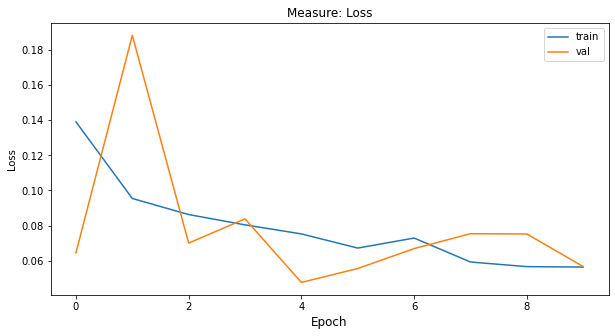

In [21]:
plot_statistics("Loss", losses_fsent)

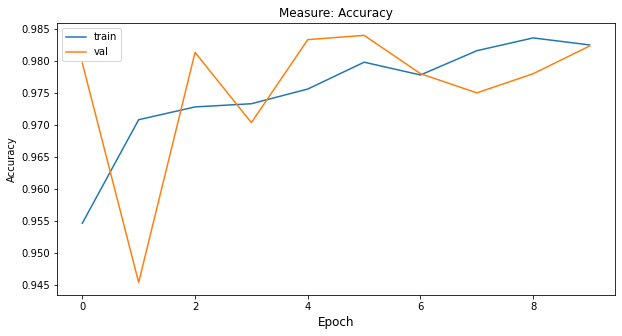

In [22]:
plot_statistics("Accuracy", accuracies_fsent)

<a id="pair"></a>
## Sentence Pair Classifier

<a id="pair-data"></a>
### Create Training Dataset, Sampler and DataLoder

In [23]:
train_dataset_pair = SentencePairDataset(train_set, tokenizer, args['model_pair']['max_length'])

Dataset loaded. Size: 1500000


In [24]:
# should be around 0.5
np.mean(train_dataset_pair.labels)

0.500198

In [25]:
train_sampler_pair = RandomSampler(
    data_source=train_dataset_pair,
    num_samples=args['model_pair']['num_train_samples'],
    replacement=True
)

In [26]:
train_dataloader_pair = DataLoader(
    train_dataset_pair,
    sampler=train_sampler_pair,
    batch_size=args['model_pair']['batch_size']
)

<a id="pair-load-model"></a>
### Load Pre-Trained Model

In [27]:
model_pair = load_model()

model_pair.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

<a id="pair-opt-sch"></a>
### Initialize Optimizer and Scheduler

In [28]:
optimizer_pair = get_optimizer(
    model_pair,
    args['model_pair']['lr'],
    args['model_pair']['adam_eps']
)

In [29]:
scheduler_pair = get_scheduler(
    optimizer_pair,
    args['model_pair']['warmup_steps'],
    len(train_dataloader_pair) * args['model_pair']['num_epochs']
)

<a id="pair-train-model"></a>
### Train Model

In [30]:
model_pair, best_epoch_pair, losses_pair, accuracies_pair, spearmans_pair = train_pair(
    model=model_pair,
    model_fsent=model_fsent,
    tokenizer=tokenizer,
    device=device,
    val_set=val_set,
    train_dataloader=train_dataloader_pair,
    optimizer=optimizer_pair,
    scheduler=scheduler_pair,
    num_epochs=args['model_pair']['num_epochs']
)

Epoch 1/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.4182; Acc: 0.7919


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7152
Best model so far! Saved checkpoint.

Epoch 2/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3725; Acc: 0.8205


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7312
Best model so far! Saved checkpoint.

Epoch 3/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3573; Acc: 0.8259


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7257

Epoch 4/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3512; Acc: 0.8302


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7353
Best model so far! Saved checkpoint.

Epoch 5/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3491; Acc: 0.8313


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7293

Epoch 6/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3375; Acc: 0.8365


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7427
Best model so far! Saved checkpoint.

Epoch 7/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3255; Acc: 0.8449


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7310

Epoch 8/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3276; Acc: 0.8442


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7482
Best model so far! Saved checkpoint.

Epoch 9/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3226; Acc: 0.8490


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7360

Epoch 10/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3176; Acc: 0.8502


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7362

Epoch 11/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3098; Acc: 0.8563


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7521
Best model so far! Saved checkpoint.

Epoch 12/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3078; Acc: 0.8550


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7560
Best model so far! Saved checkpoint.

Epoch 13/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.3084; Acc: 0.8547


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7470

Epoch 14/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2963; Acc: 0.8627


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7606
Best model so far! Saved checkpoint.

Epoch 15/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2919; Acc: 0.8637


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7573

Epoch 16/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2930; Acc: 0.8653


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7536

Epoch 17/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2848; Acc: 0.8705


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7631
Best model so far! Saved checkpoint.

Epoch 18/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2851; Acc: 0.8701


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7623

Epoch 19/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2764; Acc: 0.8756


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7645
Best model so far! Saved checkpoint.

Epoch 20/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2783; Acc: 0.8729


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7613

Epoch 21/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2757; Acc: 0.8759


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7638

Epoch 22/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2687; Acc: 0.8790


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7665
Best model so far! Saved checkpoint.

Epoch 23/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2639; Acc: 0.8805


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7631

Epoch 24/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2623; Acc: 0.8837


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7658

Epoch 25/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2595; Acc: 0.8835


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7599

Epoch 26/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2555; Acc: 0.8873


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7722
Best model so far! Saved checkpoint.

Epoch 27/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2584; Acc: 0.8841


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7670

Epoch 28/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2505; Acc: 0.8876


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7680

Epoch 29/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2491; Acc: 0.8894


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7667

Epoch 30/30
----------


  0%|          | 0/938 [00:00<?, ?batch/s]

train Loss: 0.2465; Acc: 0.8918


  0%|          | 0/500 [00:00<?, ?it/s]

val Spearman: 0.7701

Training complete in 369m 6s
Best Val Spearman: 0.772229 at Epoch: 26


<a id="pair-plots"></a>
### Plot Statistics

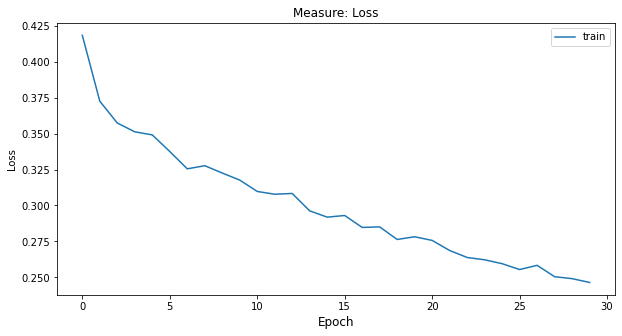

In [31]:
plot_statistics("Loss", losses_pair)

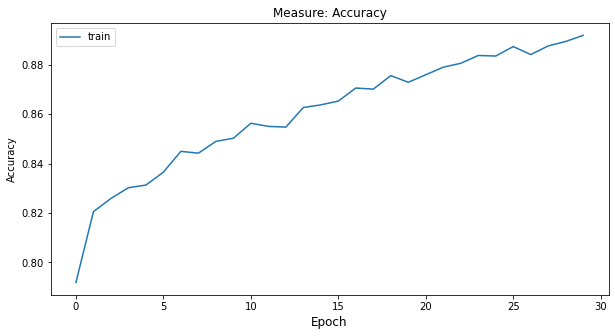

In [32]:
plot_statistics("Accuracy", accuracies_pair)

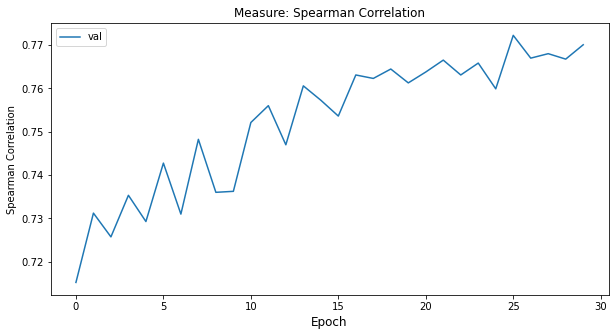

In [33]:
plot_statistics("Spearman Correlation", spearmans_pair)

<a id="submission"></a>
## Submission

In [34]:
submission = predict_submission(pred_set, device, model_fsent, model_pair, tokenizer)

submission

  0%|          | 0/2000 [00:00<?, ?it/s]

,ID,index1,index2,index3,index4,index5,index6
0,1,1,5,3,2,4,0
1,2,2,3,1,4,0,5
2,3,4,3,1,0,2,5
3,4,4,0,3,1,2,5
4,5,4,2,3,0,1,5
...,...,...,...,...,...,...,...
1995,1996,0,1,2,3,5,4
1996,1997,2,5,3,4,0,1
1997,1998,0,4,5,2,3,1
1998,1999,3,1,2,4,5,0


In [35]:
submission.to_csv('submission.csv', index=False)